## Importing the Dataset

In [25]:
drive_path  = 'E:\\FAG\\PIBIC\\python\\transferlearning\\data\\'
num_classes = 12
batch_size  = 64
n_epochs    = 32
train_file  = drive_path + 'train.txt'
test_file   = drive_path + 'test.txt'
images_path = drive_path + 'data\\'
img_rows, img_cols = 75, 75

In [26]:
import cv2

def resize_data(data, size, convert):
    if convert:
        data_upscaled = np.zeros((len(data), size[0], size[1], 3), dtype=np.uint8)
    else:
        data_upscaled = np.zeros((len(data), size[0], size[1]), dtype=np.uint8)
    
    # Redimensionar todas as imagens para o mesmo tamanho
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

In [27]:
from PIL import Image
import numpy as np

def load_images(image_paths, convert=False):
    x = []
    y = []
    
    for image_path in image_paths:
        path, label = image_path.split(' ')
        path = drive_path + 'data\\' + path
        print(f"Carregando imagem: {path}")

        # Carregar a imagem em RGB ou escala de cinza
        if convert:
            image_pil = Image.open(path).convert('RGB')
        else:
            image_pil = Image.open(path).convert('L')

        # Converter a imagem em um array NumPy
        img = np.array(image_pil, dtype=np.uint8)
        
        # Verificar se a imagem foi carregada corretamente
        if img.ndim == 2 and convert:  # Caso seja uma imagem em escala de cinza, mas deveria ser RGB
            img = np.stack((img,) * 3, axis=-1)
        
        x.append(img)
        y.append(int(label))

    # Converter listas para arrays NumPy
    x = np.array(x, dtype=object)
    y = np.array(y, dtype=np.int32)

    return x, y


In [28]:
def load_dataset(train_file, test_file, resize, convert=False, size=(224, 224)):
    with open(train_file, 'r') as arq:
        train_paths = arq.read().splitlines()
    
    train_paths = [path for path in train_paths if path.strip()]
    train_paths.sort()
    
    print("Loading training set...")
    x_train, y_train = load_images(train_paths, convert)

    with open(test_file, 'r') as arq:
        test_paths = arq.read().splitlines()
    
    test_paths = [path for path in test_paths if path.strip()]
    test_paths.sort()

    print("Loading testing set...")
    x_test, y_test = load_images(test_paths, convert)

    if resize:
        print("Resizing images...")
        x_train = resize_data(x_train, size, convert)
        x_test = resize_data(x_test, size, convert)

    # Ajustar formato se as imagens forem em escala de cinza
    if not convert:
        x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
        x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)

    print(f"Training set shape: {x_train.shape}")
    print(f"Testing set shape: {x_test.shape}")
    return (x_train, y_train), (x_test, y_test)


In [29]:
(x_train, y_train), (x_test, y_test) = load_dataset(train_file, test_file, resize=True, convert=True, size=(img_rows, img_cols))

Loading training set...
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_1606.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_2843.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_3999.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_4349.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_5758.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_6069.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_6080.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_6608.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_730.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_7786.jpg
Carregando imagem: E:\FAG\PIBIC\python\transferlearning\data\data\0_12620_0_780.jpg
Carregando imagem: E:\FAG\PIBIC\python\tran

In [30]:
## Normalize images
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [31]:
print ('\n',x_train.shape[0], 'train samples')
print ('\n',x_test.shape[0], 'test samples')


 33108 train samples

 401 test samples


In [32]:
from tensorflow.keras import utils as utils

## Convert class vectors to binary class matrices
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

## VGG19

### Declaring the model

In [33]:
from tensorflow.keras.applications.vgg19 import VGG19

In [34]:
inception_model = VGG19(weights='imagenet', include_top=False)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [36]:
model = Sequential(
    [
     inception_model,
     GlobalAveragePooling2D(),
     Dense(1024, activation='relu'),
     Dropout(0.5),
     Dense(num_classes, activation='softmax')
    ]
)

### Training the Model

In [37]:
from tensorflow.keras.optimizers import Adam

In [38]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
              )

In [39]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=n_epochs,
                    verbose=1
                    )

Epoch 1/32
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1720s 2s/step - accuracy: 0.7148 - loss: 0.8600 - val_accuracy: 0.9526 - val_loss: 0.2345
Epoch 2/32
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1660s 2s/step - accuracy: 0.9857 - loss: 0.0496 - val_accuracy: 0.9800 - val_loss: 0.1543
Epoch 3/32
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1732s 2s/step - accuracy: 0.9923 - loss: 0.0271 - val_accuracy: 0.9701 - val_loss: 0.1590
Epoch 4/32
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1690s 2s/step - accuracy: 0.9931 - loss: 0.0261 - val_accuracy: 0.9651 - val_loss: 0.1561
Epoch 5/32
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1683s 2s/step - accuracy: 0.9946 - loss: 0.0190 - val_accuracy: 0.9751 - val_loss: 0.1382
Epoch 6/32
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1583s 2s/step - accuracy: 0.9963 - loss: 0.0147 - val_accuracy: 0.9576 - val_loss: 0.2194
Epoch 7/32
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1571s 2s/step - accuracy: 0.9952 - loss: 0.0185 - val_accuracy: 0.9875 - val_loss: 0.0987
Epoch 8/32
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 1570s 2s/step - accuracy: 0.9946 -

### Evaluating the model

In [40]:
score = model.evaluate(x_test, y_test, verbose=0)

In [41]:
print ('\n----------------------------------------------------\n')
print ('Test loss:', score[0])
print ('Test accuracy:', score[1])
print ('\n----------------------------------------------------\n')


----------------------------------------------------

Test loss: 0.15064162015914917
Test accuracy: 0.9925187230110168

----------------------------------------------------



In [42]:
acc = history.history['accuracy'] # history['acc'] / history['accuracy']
val_acc = history.history['val_accuracy'] # history['val_acc'] / history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

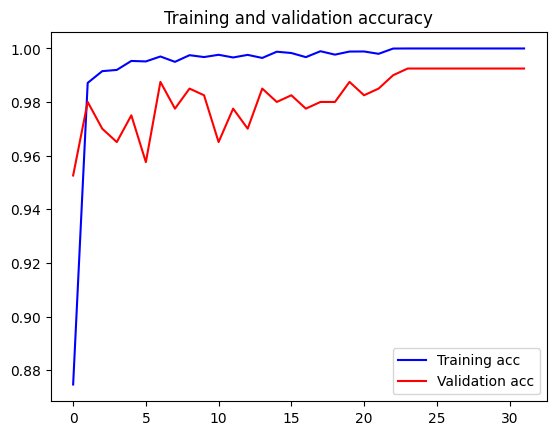

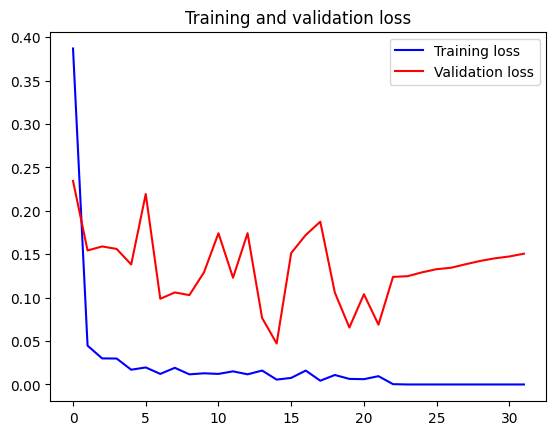

In [44]:
import matplotlib.pyplot as plt

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()